In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib

In [2]:

# Load dataset
spoof_dataset = pd.read_csv('../spoof_features.csv')
bonfide_dataset = pd.read_csv('../bonafide_features.csv')

In [3]:
# Add label columns: 0 for spoof, 1 for bonafide
spoof_dataset['label'] = 0
bonfide_dataset['label'] = 1

# Merge the datasets
combined_dataset = pd.concat([spoof_dataset, bonfide_dataset], ignore_index=True)

# Shuffle the dataset (optional but recommended)
dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Preview the result
print(dataset.head())
print(dataset['label'].value_counts())


       MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -321.300079   68.924034 -11.630466  15.247277   0.081929  -5.355102   
1 -302.844330  152.462219  -3.850286  22.434635  16.894335  28.037649   
2 -310.625214  131.728531  -2.207699  26.260344  -0.560494   9.410127   
3 -291.440430  104.713844  -3.233987  14.494747  22.734116   4.006812   
4 -236.143478   60.710751  22.075727  20.185877   1.931249  12.823346   

      MFCC_7     MFCC_8     MFCC_9   MFCC_10  ...  Spectral_Contrast_5  \
0  -2.240336  -3.254134 -11.073352 -0.462968  ...            18.296619   
1  -8.635355  -5.007866  -1.507605 -2.067190  ...            19.450157   
2 -10.213823  -0.769273  -4.603554 -2.057283  ...            20.092984   
3  -6.256077   4.401022 -14.231632  4.887247  ...            18.035892   
4 -13.016880  15.969530 -11.725241 -4.370944  ...            16.998374   

   Spectral_Contrast_6  Spectral_Contrast_7  Tonnetz_1  Tonnetz_2  Tonnetz_3  \
0            25.020027            32

In [4]:
# Extract features and target
X = dataset.iloc[:, :-1]  # Features
y = dataset['label']     # Target

In [5]:
import joblib
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [6]:
# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))

In [7]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [8]:
# First split: train + temp (validation + test)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

num_features = X_train_full.shape[1]

# Second split: validation + test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train shape: {X_train_full.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (19162, 192), Validation shape: (4106, 192), Test shape: (4107, 192)


In [9]:
# Define the DNN model
model = Sequential(name='Deep_Neural_Network')
model.add(Dense(512, activation='relu', input_shape=(X_train_full.shape[1],), name='dense_512'))
model.add(BatchNormalization(name='batch_norm_1'))
model.add(Dropout(0.5, name='dropout_1'))

model.add(Dense(256, activation='relu', name='dense_256'))
model.add(BatchNormalization(name='batch_norm_2'))
model.add(Dropout(0.5, name='dropout_2'))

model.add(Dense(128, activation='relu', name='dense_128'))
model.add(BatchNormalization(name='batch_norm_3'))
model.add(Dropout(0.5, name='dropout_3'))

model.add(Dense(len(np.unique(y_encoded)), activation='softmax', name='output_layer'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

c:\Users\PAVAN KUMAR R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Deep_Neural_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_512 (Dense)               │ (None, 512)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,882 (1.02 MB)

 Trainable params: 265,090 (1.01 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [10]:
history = model.fit(
    X_train_full, y_train_full,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)


Epoch 1/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9405 - loss: 0.1628 - val_accuracy: 0.9990 - val_loss: 0.0030
Epoch 2/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9941 - loss: 0.0176 - val_accuracy: 0.9995 - val_loss: 0.0013
Epoch 3/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9967 - loss: 0.0103 - val_accuracy: 0.9993 - val_loss: 0.0018
Epoch 4/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9976 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 2.7908e-04
Epoch 5/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9978 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 1.5227e-04
Epoch 6/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9982 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 1.4141e-04
Epoch 7/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9989 - loss: 0.0047 - val_accuracy: 0.9995 - val_loss: 4.5327e-04
Epoch 8/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9988 - loss: 0.0042 -

In [11]:
# 5. Evaluate
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%, Loss: {val_loss:.4f}")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Loss: {test_loss:.4f}")


Validation Accuracy: 99.95%, Loss: 0.0018
Test Accuracy: 100.00%, Loss: 0.0001


In [12]:
# 6. Predictions and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nDNN TEST Classification Report:\n")
target_names = [str(class_label) for class_label in label_encoder.classes_]
print(classification_report(y_test, y_pred_classes, target_names=target_names))


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

DNN TEST Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2175
           1       1.00      1.00      1.00      1932

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107



In [13]:
# 7. Validation Set Classification Report
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

print("\nDNN Validation Classification Report:\n")
print(classification_report(y_val, y_val_pred_classes, target_names=target_names))


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

DNN Validation Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2175
           1       1.00      1.00      1.00      1931

    accuracy                           1.00      4106
   macro avg       1.00      1.00      1.00      4106
weighted avg       1.00      1.00      1.00      4106



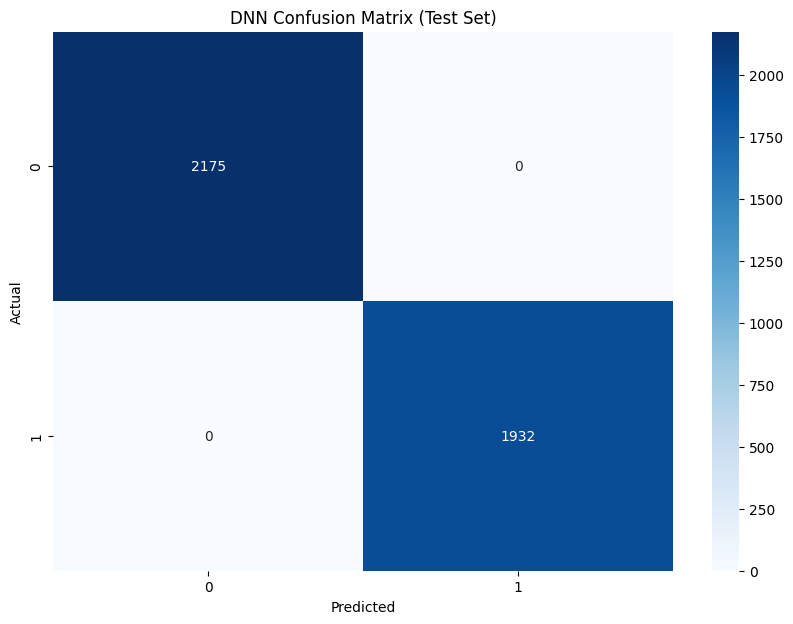

In [16]:
# 7. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('DNN Confusion Matrix (Test Set)')
plt.show()

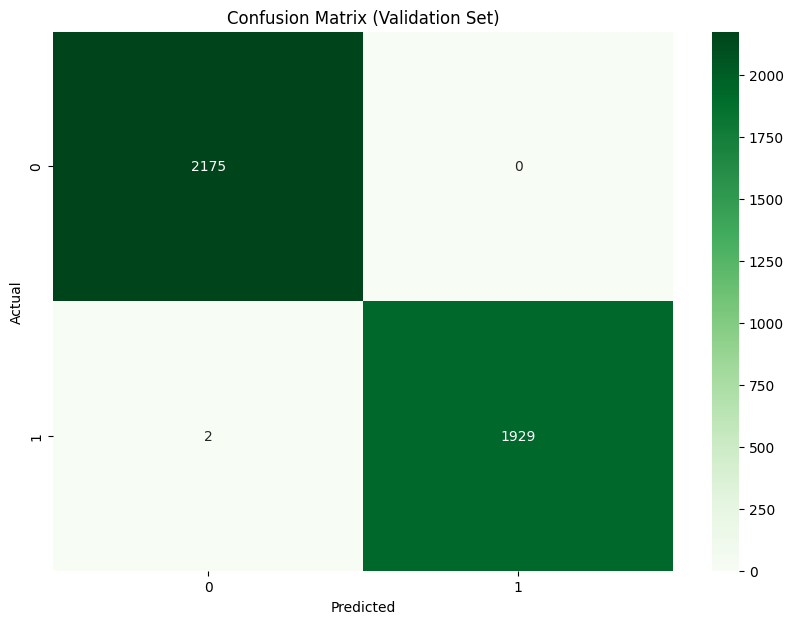

In [15]:
# 8. Confusion Matrix (Validation Set)
val_conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

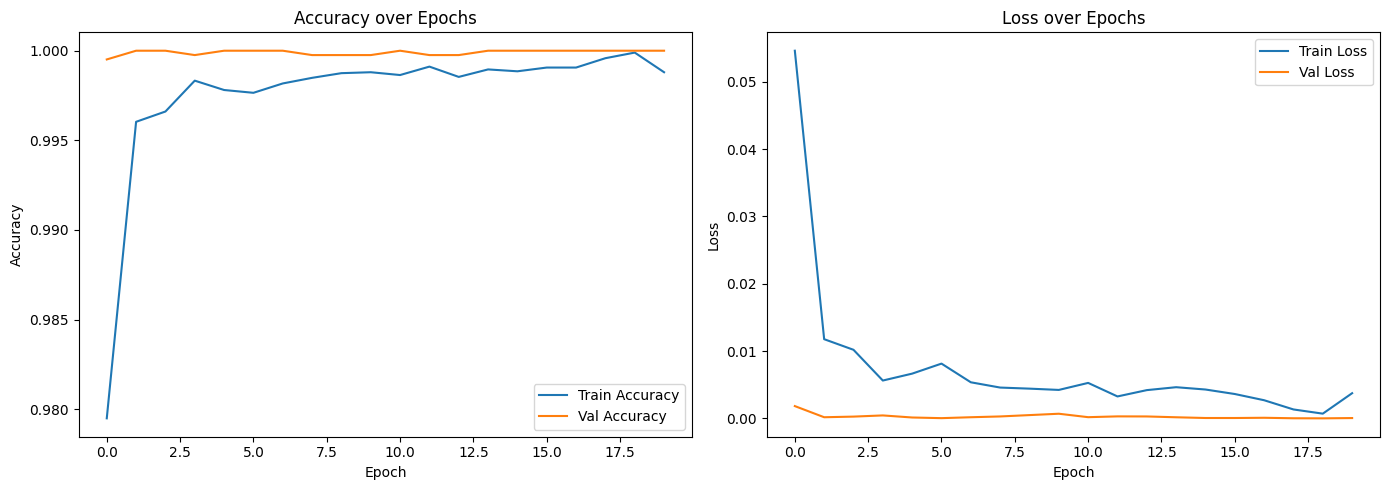

In [23]:
# 8. Plot Training History
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Save
model.save('DNN-Model.keras')